In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [3]:
# Read data
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 
    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [4]:
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = True               # Use or not pretrained models

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET,'event_attention_sum']
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
BASE     = 'grid_part_1.pkl'
PRICE    = 'grid_part_2.pkl'
CALENDAR = 'grid_part_3.pkl'
LAGS     = 'lags_df_28.pkl'
MEAN_ENC = 'mean_encoding_df.pkl'


# AUX(pretrained) Models paths

#STORES ids
STORES_IDS = ['CA_1']


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,28,56]:
        ROLS_SPLIT.append([i,j])

In [5]:
dense_cols=[ 'release', 'sell_price', 'price_max', 'price_min', 'price_std', 'price_mean', 
            'price_norm',  'price_nunique', 'item_nunique', 'price_momentum', 
            'price_momentum_m', 'price_momentum_y', 'event_attention_after', 'event_attention_bef', 
            'tm_d', 'tm_w', 'tm_m', 'tm_q', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'enc_cat_id_mean', 
            'enc_cat_id_std', 'enc_dept_id_mean', 'enc_dept_id_std', 'enc_item_id_mean', 'enc_item_id_std', 
            'sales_lag_28', 'sales_lag_29', 'sales_lag_30', 'sales_lag_31', 'sales_lag_32', 'sales_lag_33',
            'sales_lag_34', 'sales_lag_35', 'sales_lag_36', 'sales_lag_37', 'sales_lag_38', 'sales_lag_39', 
            'sales_lag_40', 'sales_lag_41', 'sales_lag_42', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
            'rolling_std_14', 'rolling_mean_28', 'rolling_std_28', 'rolling_mean_56', 'rolling_std_56', 
            'rolling_mean_168', 'rolling_std_168', 'rolling_mean_tmp_1_7', 'rolling_mean_tmp_1_14', 
            'rolling_mean_tmp_1_28', 'rolling_mean_tmp_1_56', 'rolling_mean_tmp_7_7', 'rolling_mean_tmp_7_14',
            'rolling_mean_tmp_7_28', 'rolling_mean_tmp_7_56', 'rolling_mean_tmp_14_7', 'rolling_mean_tmp_14_14',
            'rolling_mean_tmp_14_28', 'rolling_mean_tmp_14_56']

In [6]:
cat_cols=['item_id', 'dept_id','cat_id', 'event_name_1','event_type_1', 'event_name_2', 'event_type_2',\
         'NBA','event_after_weekend','event_bef_weekend','snap_CA','snap_TX','snap_WI',\
          'price_rank_dept','is_first_half_month']

In [7]:
len(dense_cols+cat_cols)

80

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model

def create_model(lr=0.002):
    
    tf.random.set_random_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=[len(dense_cols)], name='dense1')

    # Embedding input
    event_name_1_input = Input(shape=[1], name='event_name_1')
    event_type_1_input = Input(shape=[1], name='event_type_1')
    event_name_2_input = Input(shape=[1], name='event_name_2')
    event_type_2_input = Input(shape=[1], name='event_type_2')
    item_id_input = Input(shape=[1], name='item_id')
    dept_id_input = Input(shape=[1], name='dept_id')
    cat_id_input = Input(shape=[1], name='cat_id')
    
    snap_CA_input = Input(shape=[1], name='snap_CA')
    snap_TX_input = Input(shape=[1], name='snap_TX')
    snap_WI_input = Input(shape=[1], name='snap_WI')
    event_after_weekend_input = Input(shape=[1], name='event_after_weekend')
    event_bef_weekend_input = Input(shape=[1], name='event_bef_weekend')
    price_rank_dept_input = Input(shape=[1], name='price_rank_dept')
    is_first_half_month_input = Input(shape=[1], name='is_first_half_month')
    NBA_input = Input(shape=[1], name='NBA')
    
    

    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(3, 1)(event_type_2_input))
    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    
    snap_CA_emb = Flatten()(Embedding(2, 1)(snap_CA_input))
    snap_TX_emb = Flatten()(Embedding(2, 1)(snap_TX_input))
    snap_WI_emb = Flatten()(Embedding(2, 1)(snap_WI_input))
    event_after_weekend_emb = Flatten()(Embedding(2, 1)(event_after_weekend_input))
    event_bef_weekend_emb = Flatten()(Embedding(2, 1)(event_bef_weekend_input))
    price_rank_dept_emb = Flatten()(Embedding(10, 1)(price_rank_dept_input))
    is_first_half_month_emb = Flatten()(Embedding(2, 1)(is_first_half_month_input))
    NBA_emb = Flatten()(Embedding(2, 1)(NBA_input))
    

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input,
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb,cat_id_emb, 
                     snap_CA_emb,snap_TX_emb, snap_WI_emb,
                     event_after_weekend_emb,event_bef_weekend_emb,price_rank_dept_emb,
                     is_first_half_month_emb,NBA_emb])
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(4, activation="relu")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = [ dense_input,  
               event_name_1_input,  event_type_1_input,
               event_name_2_input,  event_type_2_input,
               item_id_input,  dept_id_input, cat_id_input, 
               snap_CA_input,snap_TX_input,snap_WI_input,
               event_after_weekend_input,event_bef_weekend_input,price_rank_dept_input,
               is_first_half_month_input, NBA_input]

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(lr=lr))
    return model

model = create_model(0.0002)
model.summary()

NameError: name 'keras' is not defined

In [9]:
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

In [10]:
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder

Train CA_1


0it [00:00, ?it/s]

['item_id', 'dept_id', 'cat_id', 'release', 'sell_price', 'price_max', 'price_min', 'price_std', 'price_mean', 'price_norm', 'price_rank_dept', 'price_nunique', 'item_nunique', 'price_momentum', 'price_momentum_m', 'price_momentum_y', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'is_first_half_month', 'event_bef_weekend', 'event_after_weekend', 'NBA', 'event_attention_after', 'event_attention_bef', 'tm_d', 'tm_w', 'tm_m', 'tm_q', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'enc_cat_id_mean', 'enc_cat_id_std', 'enc_dept_id_mean', 'enc_dept_id_std', 'enc_item_id_mean', 'enc_item_id_std', 'sales_lag_28', 'sales_lag_29', 'sales_lag_30', 'sales_lag_31', 'sales_lag_32', 'sales_lag_33', 'sales_lag_34', 'sales_lag_35', 'sales_lag_36', 'sales_lag_37', 'sales_lag_38', 'sales_lag_39', 'sales_lag_40', 'sales_lag_41', 'sales_lag_42', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28', 'rolling_mea

7it [00:22,  3.48s/it]
10it [00:13,  1.31s/it]
38it [19:44, 30.44s/it]
4it [00:00,  4.87it/s]


Train on 4702895 samples, validate on 85372 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/70
4702895/4702895 [==============================] - 101s 21us/sample - loss: 10.0077 - mean_squared_error: 10.0077 - val_loss: 4.8502 - val_mean_squared_error: 4.8502
Epoch 2/70
4702895/4702895 [==============================] - 121s 26us/sample - loss: 6.9010 - mean_squared_error: 6.9010 - val_loss: 5.0078 - val_mean_squared_error: 5.0078
Epoch 3/70
4702895/4702895 [==============================] - 130s 28us/sample - loss: 6.7160 - mean_squared_error: 6.7160 - val_loss: 4.4522 - val_mean_squared_error: 4.4522
Epoch 4/70
4702895/4702895 [==============================] - 132s 28us/sample - loss: 6.6029 - mean_squared_error: 6.6029 - val_loss: 4.4678 - val_mean_squared_error: 4.4678
Epoch 5/70
4702895/4702895 [==============================] - 134s 29us/sample - loss: 6.5373 - mean_squared_error: 6.5373 - val_loss: 4.3503 - val_mean_squared_error: 4.3503
Epoch 6/70
4702895/4702

Epoch 46/70
4702895/4702895 [==============================] - 131s 28us/sample - loss: 5.7939 - mean_squared_error: 5.7939 - val_loss: 4.1792 - val_mean_squared_error: 4.1792
Epoch 47/70
4702895/4702895 [==============================] - 131s 28us/sample - loss: 5.7967 - mean_squared_error: 5.7967 - val_loss: 4.1105 - val_mean_squared_error: 4.1105
Epoch 48/70
4702895/4702895 [==============================] - 133s 28us/sample - loss: 5.7839 - mean_squared_error: 5.7839 - val_loss: 4.5371 - val_mean_squared_error: 4.5371
Epoch 49/70
4702895/4702895 [==============================] - 129s 27us/sample - loss: 5.7863 - mean_squared_error: 5.7863 - val_loss: 4.0624 - val_mean_squared_error: 4.0624
Epoch 50/70
4702895/4702895 [==============================] - 129s 27us/sample - loss: 5.7623 - mean_squared_error: 5.7623 - val_loss: 4.1053 - val_mean_squared_error: 4.1053
Epoch 51/70
4702895/4702895 [==============================] - 129s 27us/sample - loss: 5.7442 - mean_squared_error: 5.7

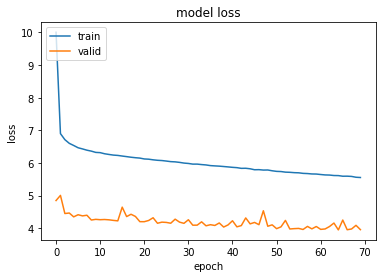

In [11]:
for store_id in STORES_IDS:
    print('Train', store_id)
    
    # Get grid for current store
    grid_df, features_columns = get_data_by_store(store_id)
    print(features_columns)
    cat_cols1=['item_id', 'dept_id','cat_id', 'event_name_1','event_type_1', 'event_name_2', 'event_type_2']
    for i, v in tqdm(enumerate(cat_cols1)):
        grid_df[v]=grid_df[v].cat.add_categories('Missing')
        grid_df[v].fillna('Missing', inplace=True)
        grid_df[v] = OrdinalEncoder(dtype="int").fit_transform(grid_df[[v]])
    cat_cols2=['NBA','event_after_weekend','event_bef_weekend','event_attention_after','event_attention_bef',\
               'snap_CA','snap_TX','snap_WI','price_rank_dept','is_first_half_month']
    for i, v in tqdm(enumerate(cat_cols2)):
        grid_df[v]=pd.to_numeric(grid_df[v])
        grid_df[v].fillna(0,inplace=True)
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validation set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    train=grid_df[train_mask].reset_index(drop=True)
    num_cols1=['rolling_std_168','rolling_mean_168','rolling_std_56','rolling_mean_56','rolling_mean_tmp_14_56',\
             'rolling_mean_tmp_7_56','rolling_mean_tmp_1_56','rolling_std_28','rolling_mean_28',\
             'sales_lag_42','rolling_mean_tmp_14_28','rolling_std_14','rolling_mean_14','sales_lag_41',\
            'sales_lag_40','sales_lag_39','sales_lag_38','sales_lag_37','sales_lag_36',\
            'sales_lag_35','sales_lag_34','rolling_mean_7','rolling_std_7','rolling_mean_tmp_7_28',\
            'sales_lag_33','sales_lag_32','sales_lag_31','sales_lag_30','sales_lag_29',\
             'rolling_mean_tmp_1_28','sales_lag_28','rolling_mean_tmp_14_14','rolling_mean_tmp_7_14',\
             'rolling_mean_tmp_14_7','rolling_mean_tmp_1_14','rolling_mean_tmp_7_7',\
             'rolling_mean_tmp_1_7','price_momentum']
    for i, v in tqdm(enumerate(num_cols1)):
        train[v]=train.groupby('id')[v].transform(lambda x:x.fillna(x.median()))
    num_cols2=['rolling_std_168','rolling_mean_168','rolling_std_56','rolling_mean_56']
    for i, v in tqdm(enumerate(num_cols2)):
        train[v] = train[v].fillna(train[v].median())
        
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    X_train = make_X(train[train_mask][features_columns])
    y_train = train[train_mask][TARGET]
    valid = (make_X(train[valid_mask][features_columns]),train[valid_mask][TARGET])
    X_valid=make_X(train[valid_mask][features_columns])
    
    valid_pred = train[valid_mask].reset_index(drop=True)
    cols = [col for col in ['id', 'd']]
    valid_pred = valid_pred[cols]
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    grid_df = grid_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    grid_df = grid_df[keep_cols]
    grid_df.to_pickle('test_'+store_id+'.pkl')
    del grid_df
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
                                              
    history=model.fit(X_train, 
                      y_train,
                      batch_size=2 ** 14,
                      epochs=70,
                      shuffle=True,
                      validation_data=valid)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
    valid_pred['pred']=model.predict(X_valid, batch_size=2 ** 14)
    valid_pred.to_pickle('valid_pred_nn'+store_id+'.pkl')
    del X_valid, valid_pred
    gc.collect()
    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration

    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    del X_train, y_train
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns

In [12]:
np.sqrt(3.9583)

1.9895476872897517

In [13]:
# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

# Join back the Test dataset with 
# a small part of the training data 
# to make recursive features
base_test = get_base_test()

# Timer to measure predictions time 
main_time = time.time()

# Loop over each prediction day
# As rolling lags are the most timeconsuming
# we will calculate it for whole day
for PREDICT_DAY in range(1,29):    
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)
        
    for store_id in STORES_IDS:
        
        # Read all our models and make predictions
        # for each day/store pairs
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = base_test['store_id']==store_id
        
        mask = (day_mask)&(store_mask)
        
        X_test=make_X(grid_df[mask][MODEL_FEATURES])
        base_test[TARGET][mask] = model.predict(X_test,batch_size=2 ** 14)
        del X_test
        gc.collect()
    
    # Make good column naming and add 
    # to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)

Predict | Day: 1
##########  1.21 min round |  1.21 min total |  3693.24 day sales |
Predict | Day: 2
##########  1.33 min round |  2.54 min total |  3584.47 day sales |
Predict | Day: 3
##########  2.22 min round |  4.76 min total |  3565.20 day sales |
Predict | Day: 4
##########  3.38 min round |  8.14 min total |  3737.49 day sales |
Predict | Day: 5
##########  3.30 min round |  11.44 min total |  4051.49 day sales |
Predict | Day: 6
##########  3.27 min round |  14.72 min total |  5262.76 day sales |
Predict | Day: 7
##########  3.26 min round |  17.98 min total |  5771.77 day sales |
Predict | Day: 8
##########  3.21 min round |  21.20 min total |  4282.30 day sales |
Predict | Day: 9
##########  3.24 min round |  24.43 min total |  4168.17 day sales |
Predict | Day: 10
##########  3.24 min round |  27.67 min total |  4059.85 day sales |
Predict | Day: 11
##########  3.20 min round |  30.87 min total |  3836.13 day sales |
Predict | Day: 12
##########  3.22 min round |  34.10 mi

NameError: name 'fold_' is not defined

In [14]:
all_preds.to_csv('nn_CA_1.csv',index=False)